# Text classification of movie reviews with Naive Bayes

<p><em>Completed by Geovanna Meier</em></p>

*** 
<p>This mini-project, covers the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. This mini-project is based on <a href = "https://github.com/cs109/2015lab10"> Lab 10 of Harvard's CS109 class</a>.</p>

<p><em><b>Skills:</b> EDA, Text Analysis, Naive Bayes</em></p>

****

# Table of Contents

* [Set up Environment](#setup)
* [Rotten Tomatoes Dataset](#dataset)
* [EDA](#movies)
    * [Movies over time](#movies)
    * [Distribution of Ratings](#distribution)
    * [Average Ratings](#averageratings)
* [Text Analysis of Movie Reviews](#textanalysis)
    * [Feature Extraction How-To](#features)
* [Naive Bayes Classifier](#naivebayes)
    * [Baseline Classifier](#baseline)
* [Picking Hyperparameters for Naive Bayes](#tuningnb)
    * [Tuning the Classifier](#tuningc)
    * [Building the Classifier with the Best Parameters](#bulding)
    * [Interpretation](#interpretation)
* [Predicting Freshness of a New Review](#newreview)
* [Conclusions](#conclusions)

<a id='setup'></a>

# Set up Environment

In [1]:
# Show warning only the first time the cell is run
import warnings
warnings.filterwarnings('ignore')

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
# import moduoles
import numpy as np
import scipy as sp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
#from six.moves import range

# Set matplotlib
_=plt.rcParams['figure.figsize'] = [12,6]
_=plt.rcParams['axes.xmargin'] = 0.1
#plt.style.use(['seaborn-poster'])
plt.style.use(['fivethirtyeight'])
#plt.tight_layout(pad=4)


# 'double resolution plot output for Retina screens'
%config InlineBackend.figure_format = 'retina'

# Setup Pandas
#pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.notebook_repr_html', True)


# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3})
#sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth": 2.5})

<a id='dataset'></a>

# Rotten Tomatoes Dataset

In [3]:
critics = pd.read_csv('./critics.csv')
#drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.shape
critics.head(3)

(15561, 8)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story


In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Unique number of critics: {:d}".format(n_critics))
print("Unique number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Unique number of critics: 623
Unique number of movies:  1921


The dataset contains 15,661 reviews of 1921 movies done by 623 critics.

In [5]:
# change review date to datetime variable to explore changes over time
critics['review_date']=pd.to_datetime(critics['review_date'],format = "%Y/%m/%d",exact=True)

<a id='movies'></a>

# EDA

## Movies over time
<p>The first analysis was done to compare how movie ratings have change over time. The assumption is that the number of releases, entertainment film critics and reviews have steady increased over time as more people rely on general reviews to decide on products and services.</p>

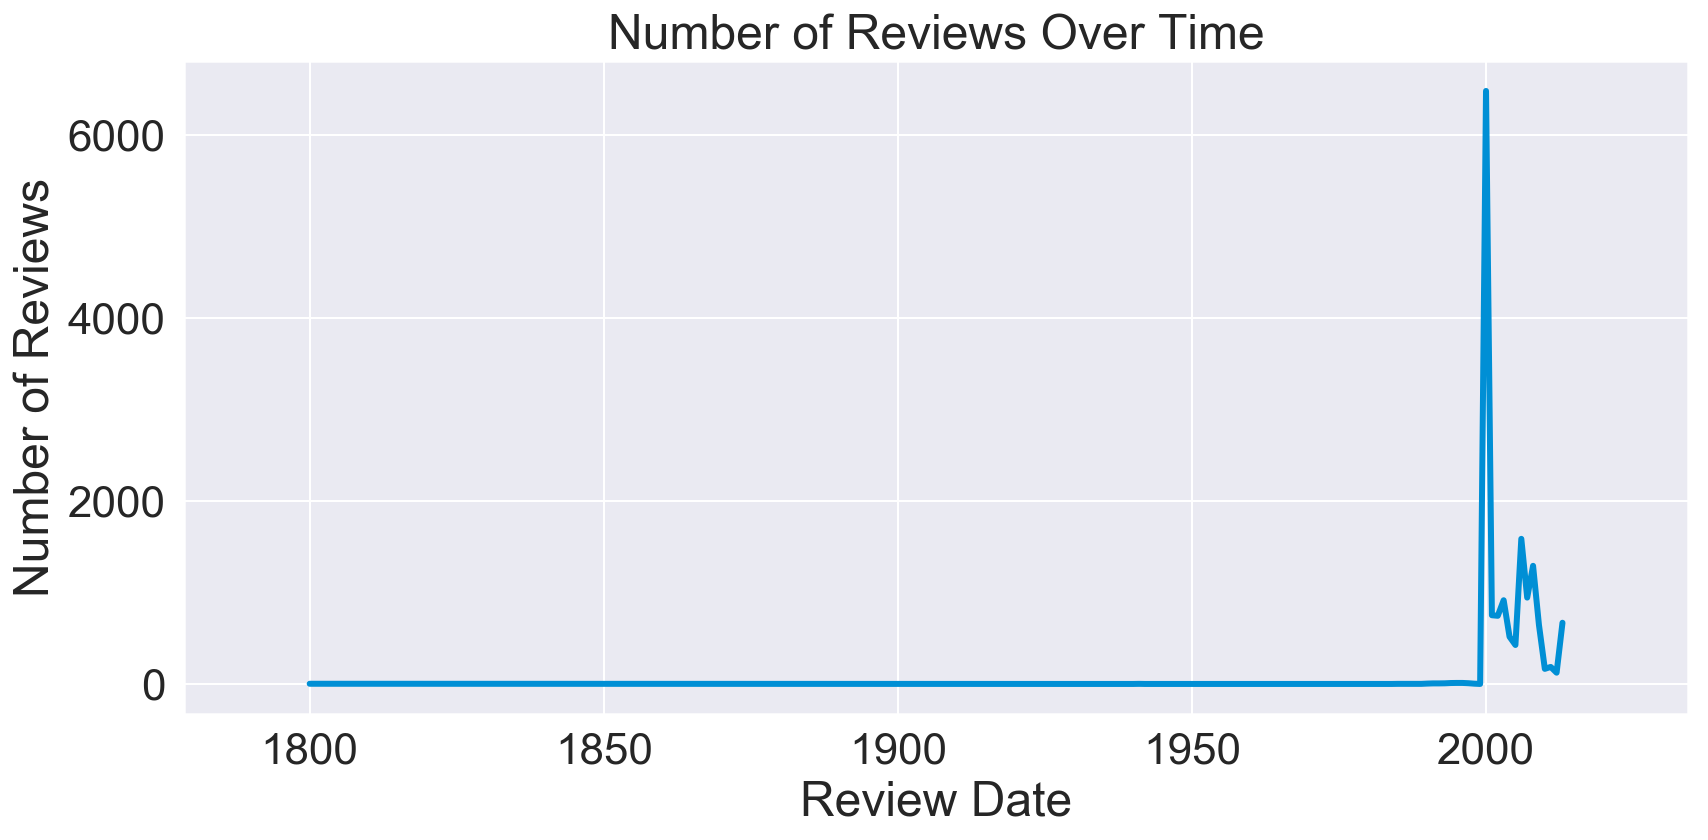

In [6]:
plt.rcParams['figure.figsize'] = [12,6]
reviews = critics.groupby(critics['review_date'].dt.year).size().reset_index()
#reviews = reviews.loc[reviews['review_date']>=1929]
_=plt.plot(reviews['review_date'], reviews[0])
_=plt.xlabel('Review Date')
_=plt.ylabel('Number of Reviews')
_=plt.title('Number of Reviews Over Time')

<p>A trend line of the recorded data shows that there are not many reviews before 2000, when there was a 'sudden' explosion of reviews. In order to take a better look at the data, a scatter plot was done scaling the number of reviews using the <code>log10</code>.</p>

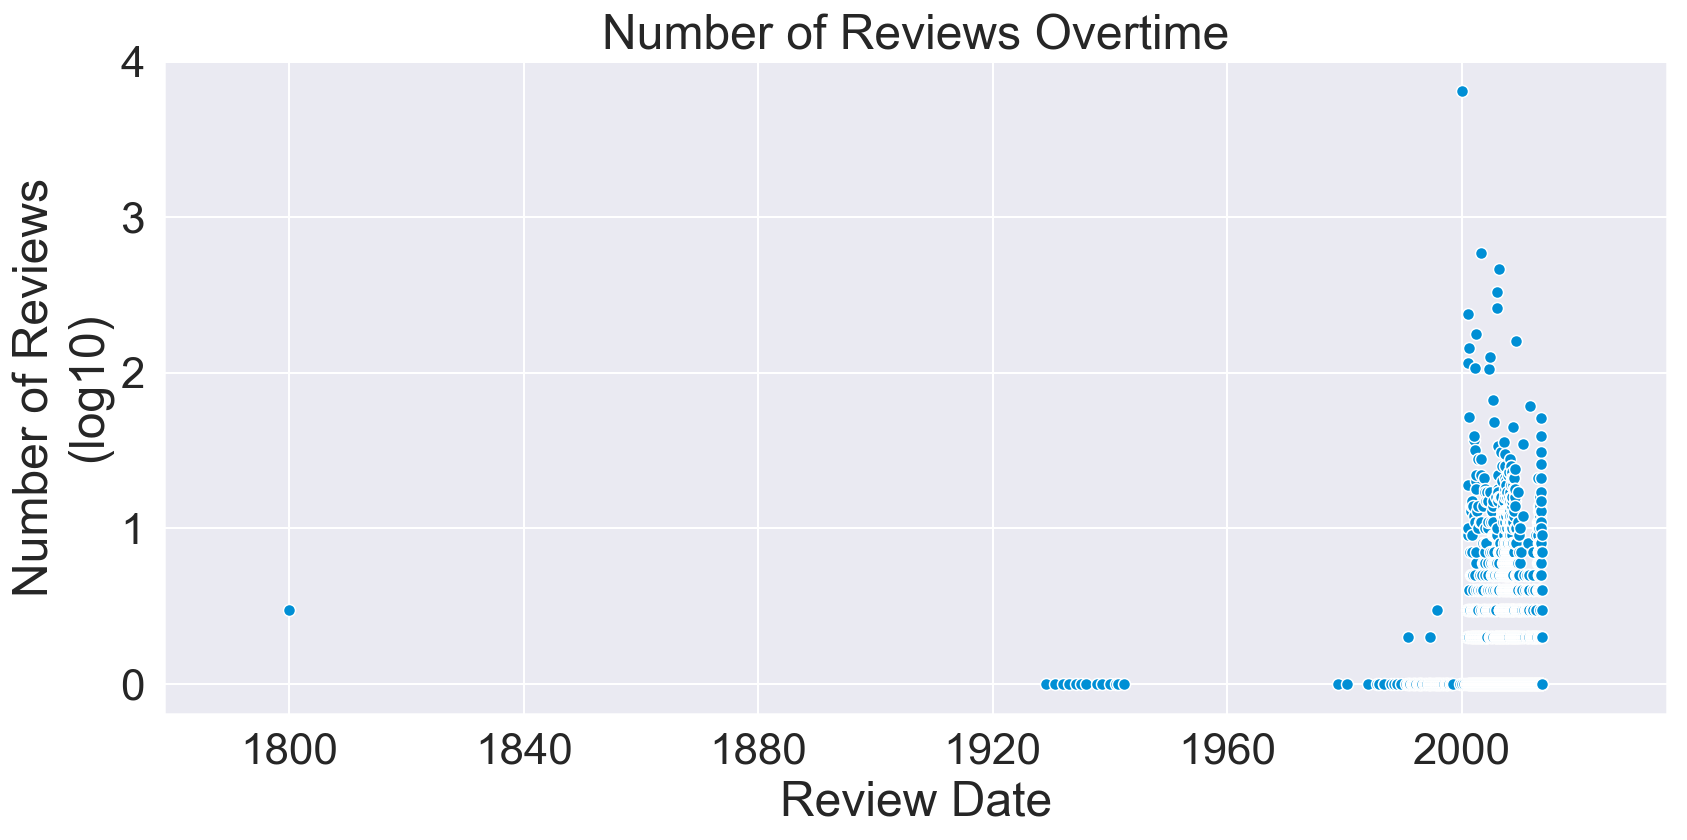

In [7]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# group reivews by date
reviews_scatter = critics.groupby(critics['review_date']).size().reset_index()
# plot using log10 for the review countt
_=sns.scatterplot(reviews_scatter['review_date'], np.log10(reviews_scatter[0]))
# labels
_=plt.xlabel('Review Date')
_=plt.ylabel('Number of Reviews\n(log10)')
_=plt.title('Number of Reviews Overtime')

<p>The scatter plot shows that there are two big time gaps. There are some reviews from 1800, which is either the default for missing dates or an input error; there are a couple of reviews between 1920 and 1940, followed by another time gap until the 1990 with a few reviews all the way through 2000 when there are over 6000 reviews.</p>
<p>Zooming in even more shows that the 'sudden' increase in number of reviews is that 1,389 movies were recorded with the same date, '2000-01-01'.</p>

In [8]:
critics[critics['review_date'] == '2000'][['title','review_date']].drop_duplicates().head(3)

,title,review_date
10,Toy story,2000-01-01
30,Jumanji,2000-01-01
39,Grumpy Old Men,2000-01-01


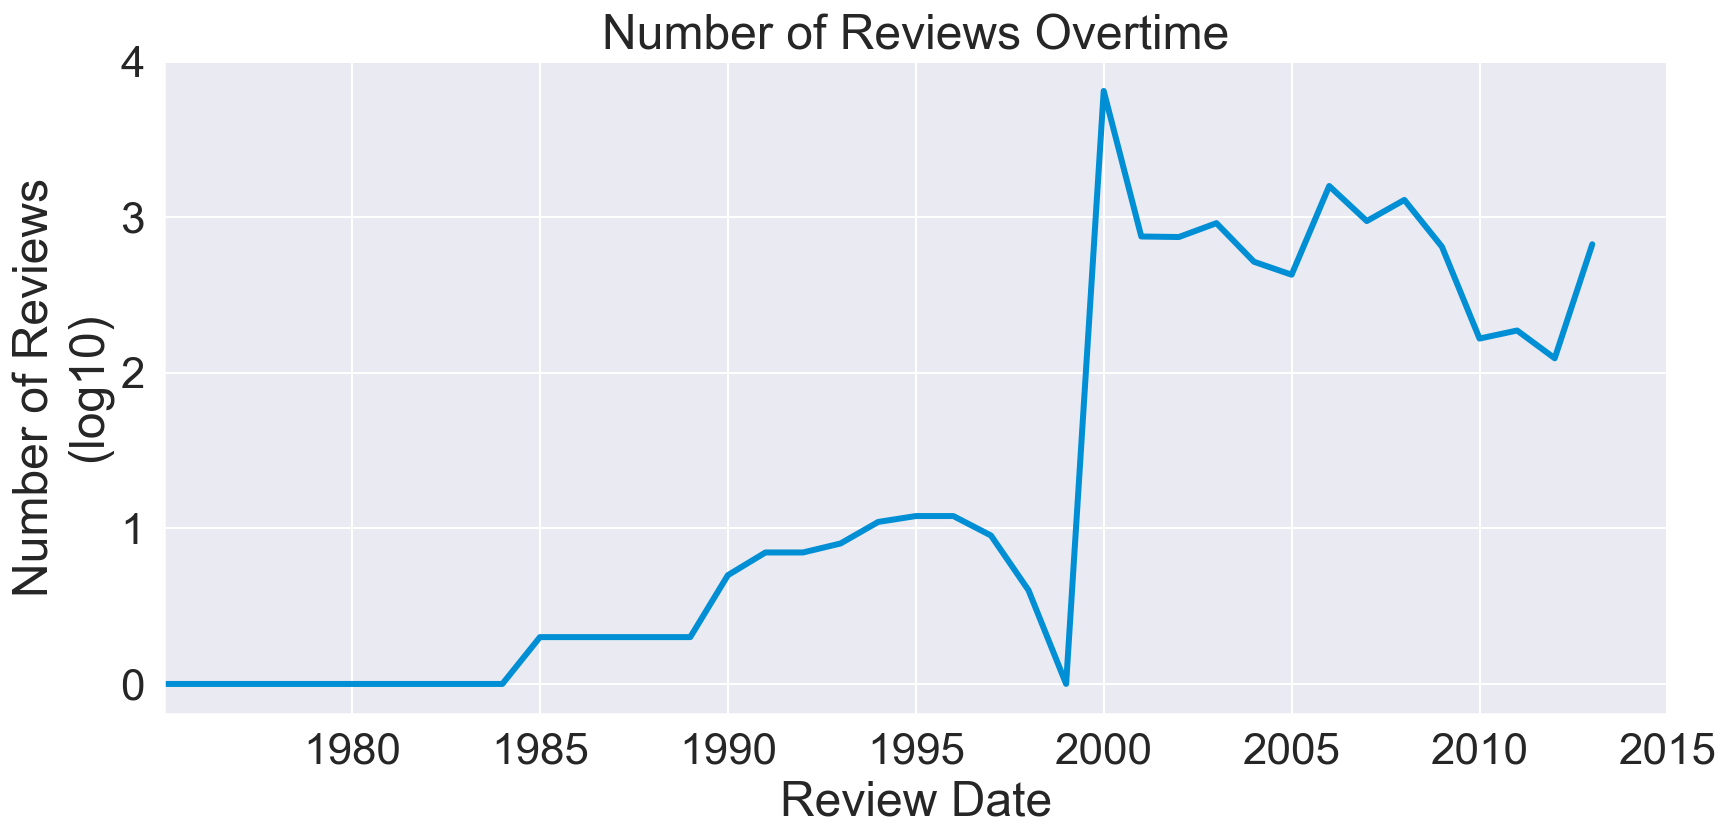

In [9]:
_=plt.plot(reviews['review_date'], np.log10(reviews[0]))
_=plt.xticks([1980,1985,1990,1995,2000,2005,2010, 2015])
_=plt.xlim(1975,2015)
_=plt.xlabel('Review Date')
_=plt.ylabel('Number of Reviews\n(log10)')
_=plt.title('Number of Reviews Overtime')

## Oldest and Latest Review
<p>The next step was to look at the oldest and latest recorded review. Leaving aside the three movies with reviews from 1800,the oldest recorded review was a negative review of the movie 'The Broadway Melody' from 1929, . The latest review is from October 2013 for 'Night of Living Dead', which obtained a positive review.</p>
<p>After this preliminary analysis is obvious that there are several inconsistencies when it comes to the recorded review dates. Hence, time series analysis may not be appropriate for this dataset, due to the inconsistencies in the recorded review dates.</p>

In [10]:
print('Oldest review:', critics.review_date.min())
print('Most recent review:', critics.review_date.max())

# aside from the three mislabeled movies, which are the oldest reviews
_=critics.loc[critics['review_date']!='1800-01-01']['review_date'].min()
print('\nOldest accurately recorded reviews:')
critics.loc[critics['review_date']=='1929-02-01']
print('\nMost recent recorded review:\n')
critics.loc[critics['review_date']=='2013-10-07']
# which movies have the wrong date
print('\nMovies with mislabeled review date:\n')
critics.loc[critics['review_date']=='1800-01-01']



Oldest review: 1800-01-01 00:00:00
Most recent review: 2013-10-07 00:00:00

Oldest accurately recorded reviews:


,critic,fresh,imdb,publication,quote,review_date,rtid,title
16362,James Berardinelli,rotten,19729,ReelViews,The Broadway Melody has not stood the test of ...,1929-02-01,18773,The Broadway Melody



Most recent recorded review:



,critic,fresh,imdb,publication,quote,review_date,rtid,title
8365,Amos Barshad,fresh,63350,New York Magazine,If [Romero's] original vision of the undead lo...,2013-10-07,50375489,Night of the Living Dead



Movies with mislabeled review date:



,critic,fresh,imdb,publication,quote,review_date,rtid,title
8143,James Berardinelli,fresh,32976,ReelViews,The result exhibits that the director is capab...,1800-01-01,17080,Rebecca
10478,James Berardinelli,fresh,92005,ReelViews,It's as effective in 2009 as it was upon its i...,1800-01-01,16272,Stand by Me
10865,Owen Gleiberman,fresh,103644,Entertainment Weekly,"A grimly seductive end-of-the-world thriller, ...",1800-01-01,14276,Alien³


<a id='distribution'></a>

## Distribution of Ratings
The distribution of ratings shows that over 60% of the reviews are positive reviews, indicating that the typical movie in the dataset is above average and critics tend to recommend them.

Proportion of 'Fresh' ratings: 0.609



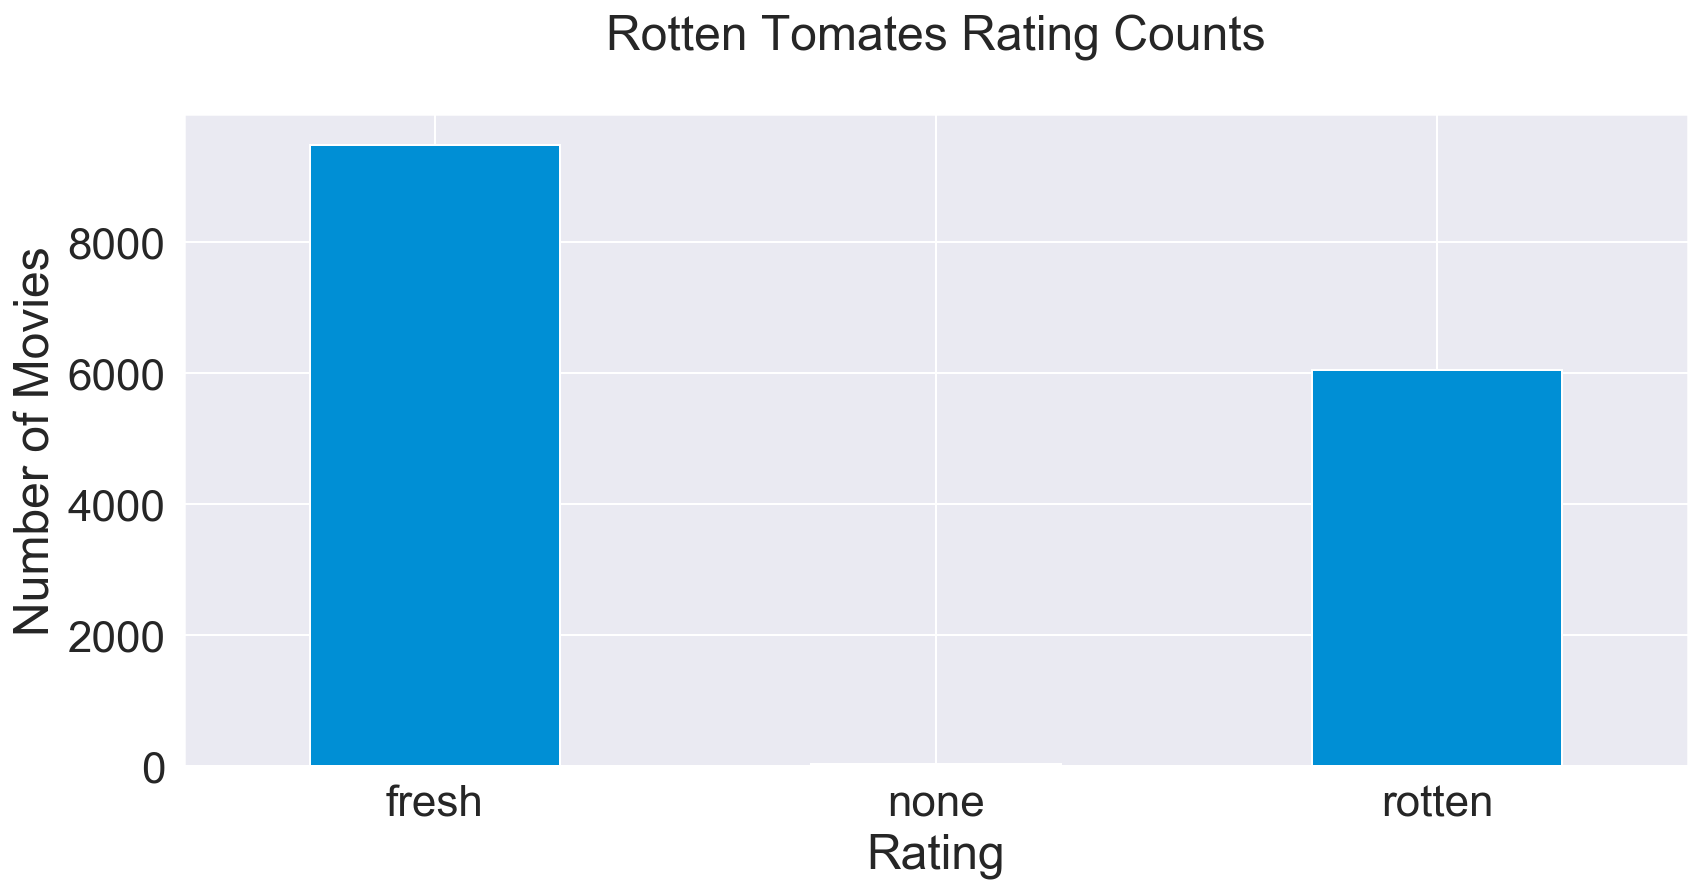

In [11]:
# create a copy of data
df = critics.copy()

# proportion of roten
df['fresh'] = df.fresh == 'fresh'# set fresh rating to True or False otherwise
p = (df.fresh.sum()/len(df))
_=critics.groupby('fresh').size().plot(kind = 'bar', rot = 0)
_=plt.xlabel('Rating')
_=plt.ylabel('Number of Movies')
_=plt.title('Rotten Tomates Rating Counts\n')
print("Proportion of 'Fresh' ratings: %.3f\n"%(p))

<a id='avergageratings'></a>

## Average Rating
The previous graph shows that movies reviews are positive. So what is the average rating per critic? The first part of the analysis looked at critics who had over 100 reviews to see the individual average ratings.

In [12]:
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

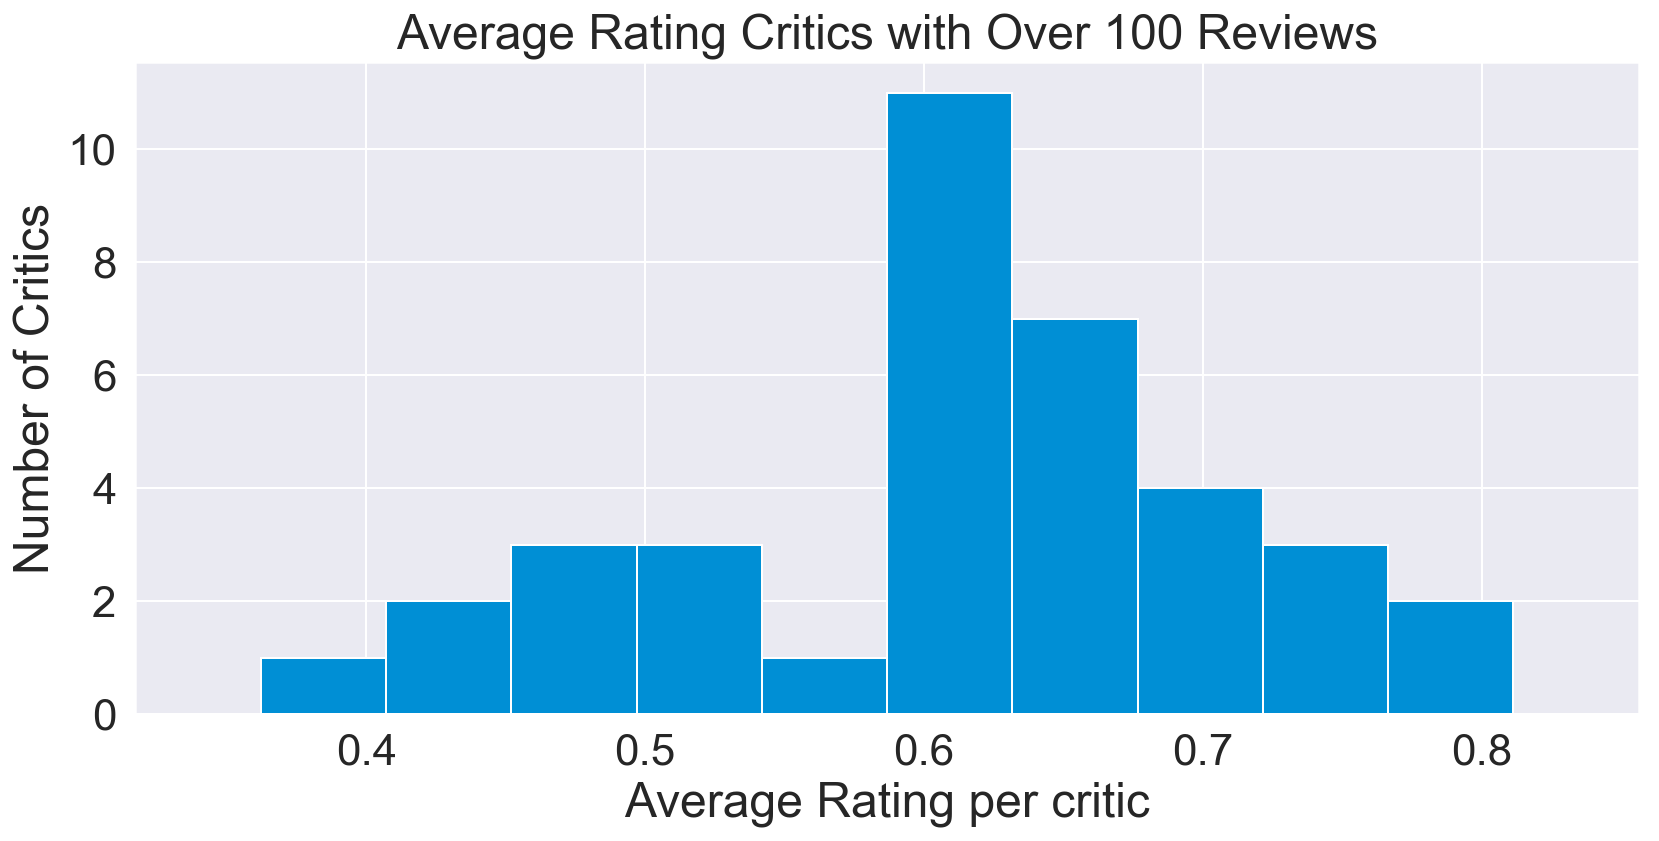

In [13]:
# look at the distribution of avg. ratings 
_=means[counts > 100].hist(edgecolor='w', lw=1) #bins=int(np.sqrt(len(counts)))
_=plt.xlabel("Average Rating per critic")
_=plt.ylabel("Number of Critics")
_=plt.yticks([0, 2, 4, 6, 8, 10])
_=plt.title('Average Rating Critics with Over 100 Reviews')

<p>The above histogram agrees with the proportion of 'fresh' reviews. The distribution of average ratings is not symmetrical and most reviews are above average.</p>
<p>Critics with over 100 reviews tend to give more positive reviews. The majority of ratings are above 0.6, indicating that most movies are considered fair or above average. Only a small number of critics gave below average ratings (less than 0.5) and from these data, none gave a truly bad review (less  0.2).</p>
<p>Changing the bin size, as shown in the histogram below, did not drastically change the distribution of the average. </p> 

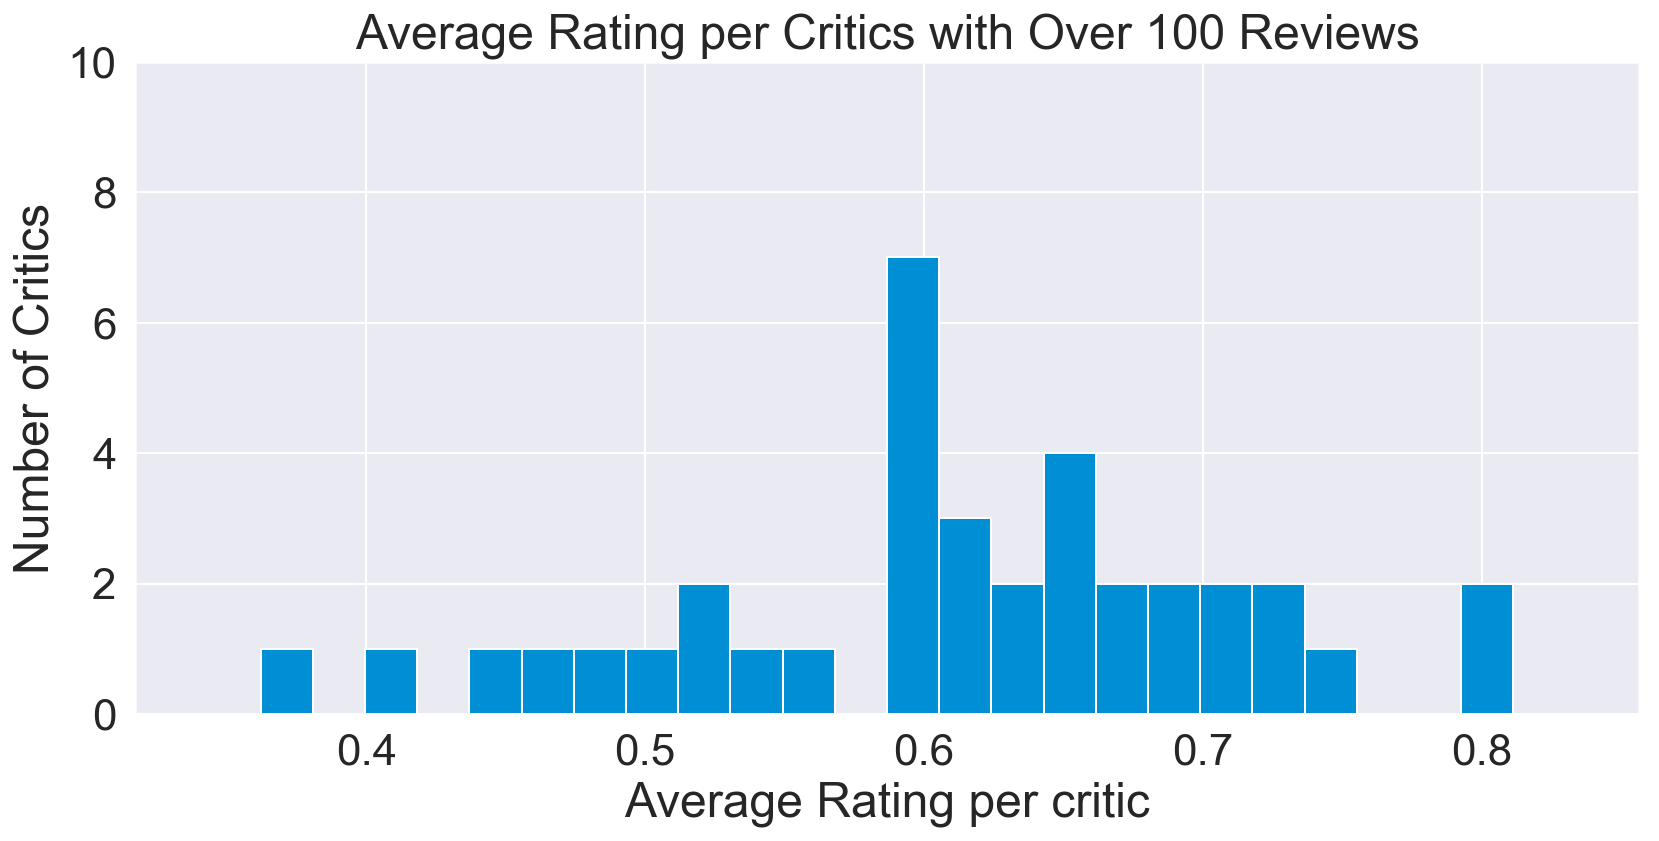

In [14]:
# look at the distribution of avg. ratings 
_=means[counts > 100].hist(bins=int(np.sqrt(len(counts))),edgecolor='w', lw=1) #
_=plt.xlabel("Average Rating per critic")
_=plt.ylabel("Number of Critics")
_=plt.yticks([0, 2, 4, 6, 8, 10])
_=plt.title('Average Rating per Critics with Over 100 Reviews')

### How About Most Critics?
<p>The next step was to analyze a greater set of critics. This time the idea was to see if the average rating changes when we also take into consideration critics with only a couple of reviews.</p>
<p>After subsetting the dataset to include critics with five or more reviews, a new histogram was created and the distribution became nearly normally distributed. Even though the typical rating is still around 0.6, critics with less number of reviews seem to be more critic and provide ratings that are below average.</p>

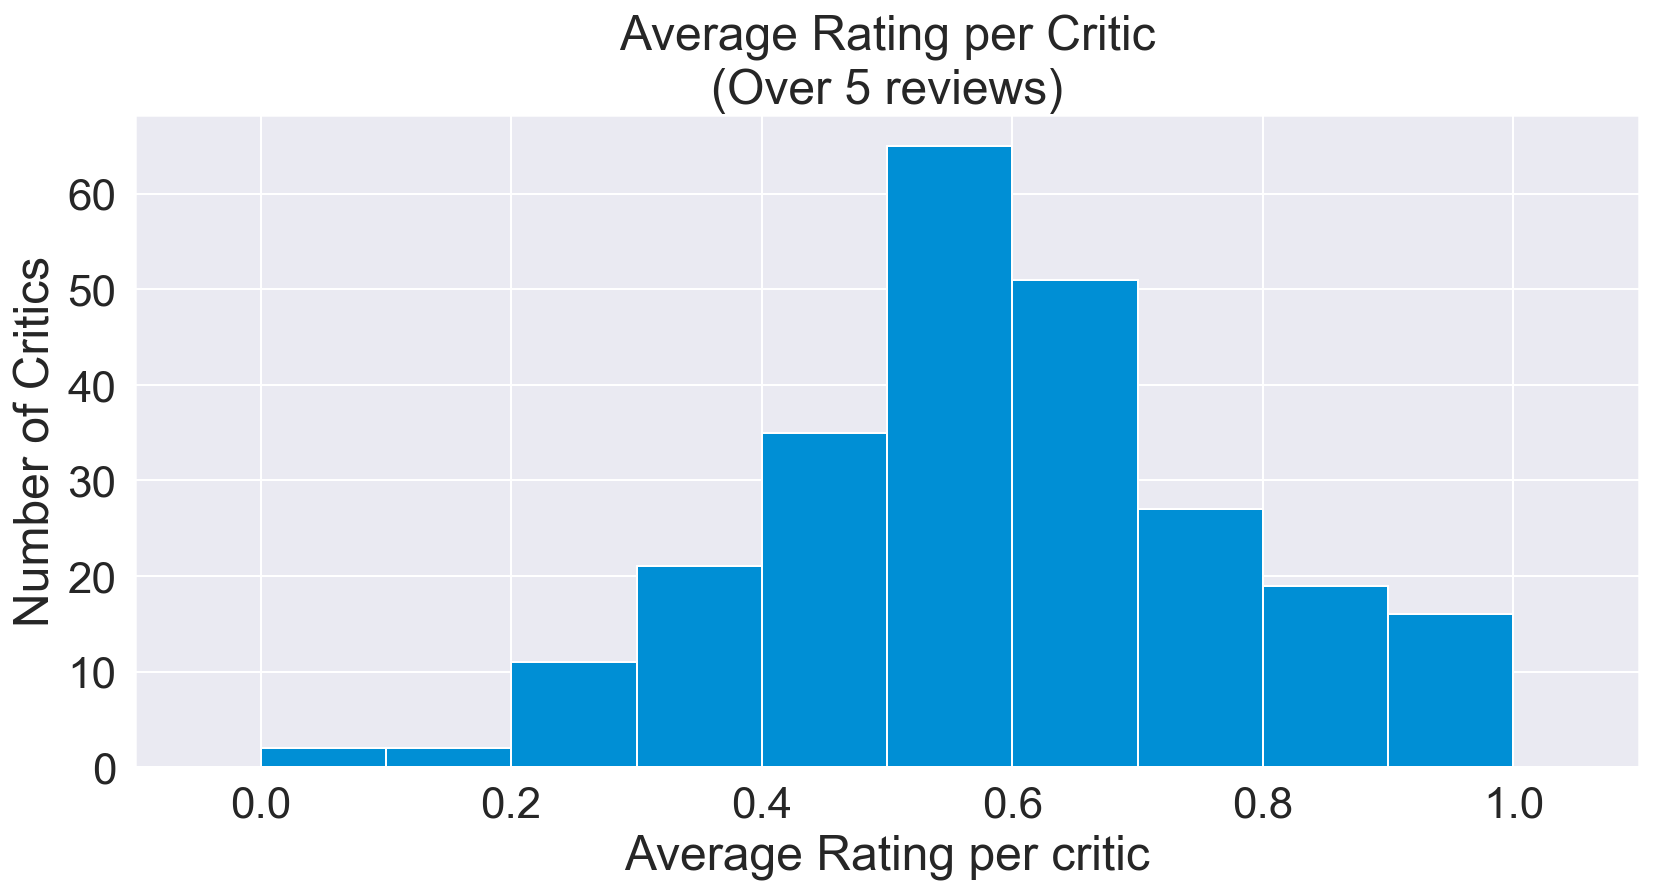

In [15]:
# look at the distribution of avg. ratings 
_=means[counts>=5].hist(edgecolor='w', lw=1) #bins=int(np.sqrt(len(counts)))
_=plt.xlabel("Average Rating per critic")
_=plt.ylabel("Number of Critics")
_=plt.title('Average Rating per Critic\n(Over 5 reviews)')

<a id='textanalysis'></a>

# Text Analysis of Movie Reviews

<p>Basic information retrieval can be accomplished using the CounterVectorizer from scikit-learn, wich turns text from a set of documents into a word count matrix. A simple example is given below using the definition of film criticism from <a href ='https://en.wikipedia.org/wiki/Film_criticism'>wikipedia</a>. Once the sample text was obtained from the website, the CounterVectorizer was used for text retrieval.</p>

<a id='textanalysis'></a>

## Feature Extraction How-To

In [16]:
import requests
from bs4 import BeautifulSoup

# url with definition
url = 'https://en.wikipedia.org/wiki/Film_criticism'
# package the request, send the request and catch the response
r = requests.get(url)
# extract the text from the response
html_txt = r.text
#creTEa BeautifulSoup object
soup = BeautifulSoup(html_txt, 'html.parser')

In [17]:
# get the definition and print the definition
origin = soup.p
#definition = origin.get_text()
definition = [text for text in origin.stripped_strings]

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

print("Original text is:\n",definition)

# Convert the text documents into a matrix of word counts
vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
_=vectorizer.fit(definition)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(definition)
# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()
print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is:
 ['Film criticism', 'is the analysis and evaluation of', 'films', 'and the film medium. The concept is often used interchangeably with that of film reviews. A film review implies a recommendation aimed at consumers, however not all film criticism takes the form of reviews.']

Transformed text vector is 
[[0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 1 1 1 1 0 4 0 1 1 1 1 1 1 1 2 1 1 1 2 1 1 3 1 1]]

Words for each feature:
['aimed', 'all', 'analysis', 'and', 'at', 'concept', 'consumers', 'criticism', 'evaluation', 'film', 'films', 'form', 'however', 'implies', 'interchangeably', 'is', 'medium', 'not', 'of', 'often', 'recommendation', 'review', 'reviews', 'takes', 'that', 'the', 'used', 'with']


In [19]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

<a id='naivebayes'></a>

# Naive Bayes Classifier
<p>The first step in implementing a classifier to determine if a review is positive (fresh) or negative (rotten) is to separate the reviews from the class label (fresh or rotten) and extract the text from current reviews. Then a vocabulary is built from the known words, the text is converted into a bag of words to train the classifier.</p>

In [20]:
# import modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

## Baseline Classifier

In [21]:
# set random seed to replicate results
np.random.seed(44)

In [22]:
#code from 
def make_xy(document, column, vectorizer = None, max_df=1.0, min_df=1):
    """return a sparse matrix of token counts for the reviews text and 
    a one dimmensional array with the class label"""
    #select a vectorizer
    if vectorizer is None:
        #Convert the text documents into a matrix of word counts
        vectorizer = CountVectorizer(max_df, min_df)
    #learn the vocabulary dictionary and return term-document matrix.    
    x = vectorizer.fit_transform(document[column])
    #x = x.toarray()
    # extract the labels and turn them into 1-0
    y = (document.fresh == 'fresh').values.astype(np.int)
    return x,y, #feat

In [23]:
x,y = make_xy(document=critics, column='quote', vectorizer=None)

In [24]:
#split the data into train and test set
xtrain, xtest, ytrain, ytest =train_test_split(x, y,test_size = 0.25)

In [25]:
# initialize the classifier
nbm = MultinomialNB()
#call `fit` to learn the vocabulary
_=nbm.fit(xtrain, ytrain)
# test the classifier on unseen data
nb_pred=nbm.predict(xtest)

In [26]:
# check accuracy on train and test sets
print('accuracy on train set: %.3f'%(nbm.score(xtrain, ytrain)))
print('accuracy on test set: %.3f'%(nbm.score(xtest, ytest)))
print('classification_report:')
print(classification_report(ytest, nb_pred))

accuracy on train set: 0.921
accuracy on test set: 0.768
classification_report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1567
           1       0.78      0.85      0.82      2324

   micro avg       0.77      0.77      0.77      3891
   macro avg       0.76      0.75      0.75      3891
weighted avg       0.77      0.77      0.76      3891



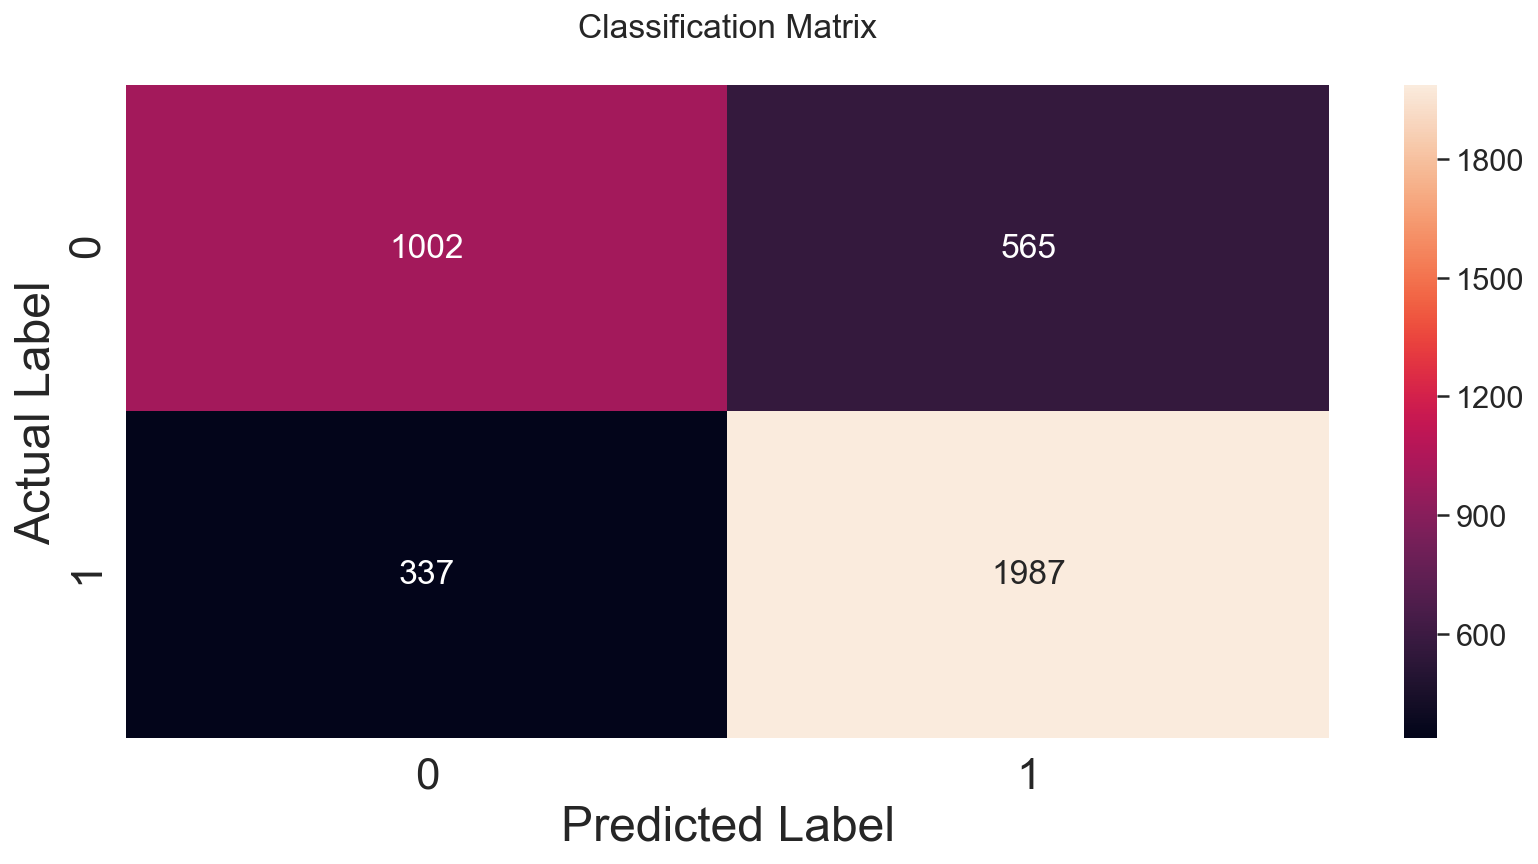

In [27]:
# plot classificaton accuracy
cm = metrics.confusion_matrix(ytest, nb_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)
_=sns.set(font_scale=1.4)
_=sns.heatmap(pd.DataFrame(cm), annot=True, fmt ='g')
_=plt.title('Classification Matrix\n')
_=plt.xlabel('Predicted Label')
_=plt.ylabel('Actual Label')

### Results:
<p>The classifier performed well on new data, but it seemed to have memorized the training data as seen on the accuracy of the train set of 92%. Hence with this classifier, the data was Overfitted.</p>

***

<a id='tuningnb'></a>

## Picking Hyperparameters for Naive Bayes and Text Maintenance 
#### Tuning the Naive Bayes Classifier and Text Maintenance
<p>Comparing different parameters for minimum frequency of words in the vocabulary and the classifier can significantly improve the performance of the classifier when compared to a basis model trained with the default values.</p>
<p>The following section will try different parameters for the classifier to evaluate performance.</p>

### Cumulative distribution of document frequencies

In [28]:
# plot cumulative distribution
def ecdf(data):
    """return x-axis with document count 
    and y-axis with the percentage of words"""
    # word count
    n = len(data)
    x_axis = sorted(data)
    # percentage of words
    y_axis = np.arange(1, n+1)/n
    return x_axis, y_axis

In [29]:
# get the words from the documents
doc_freq = list(np.sum(x.toarray(), axis =0))
# get the x-axis and y-axis for the plot
x_axis, y_axis = ecdf(doc_freq)

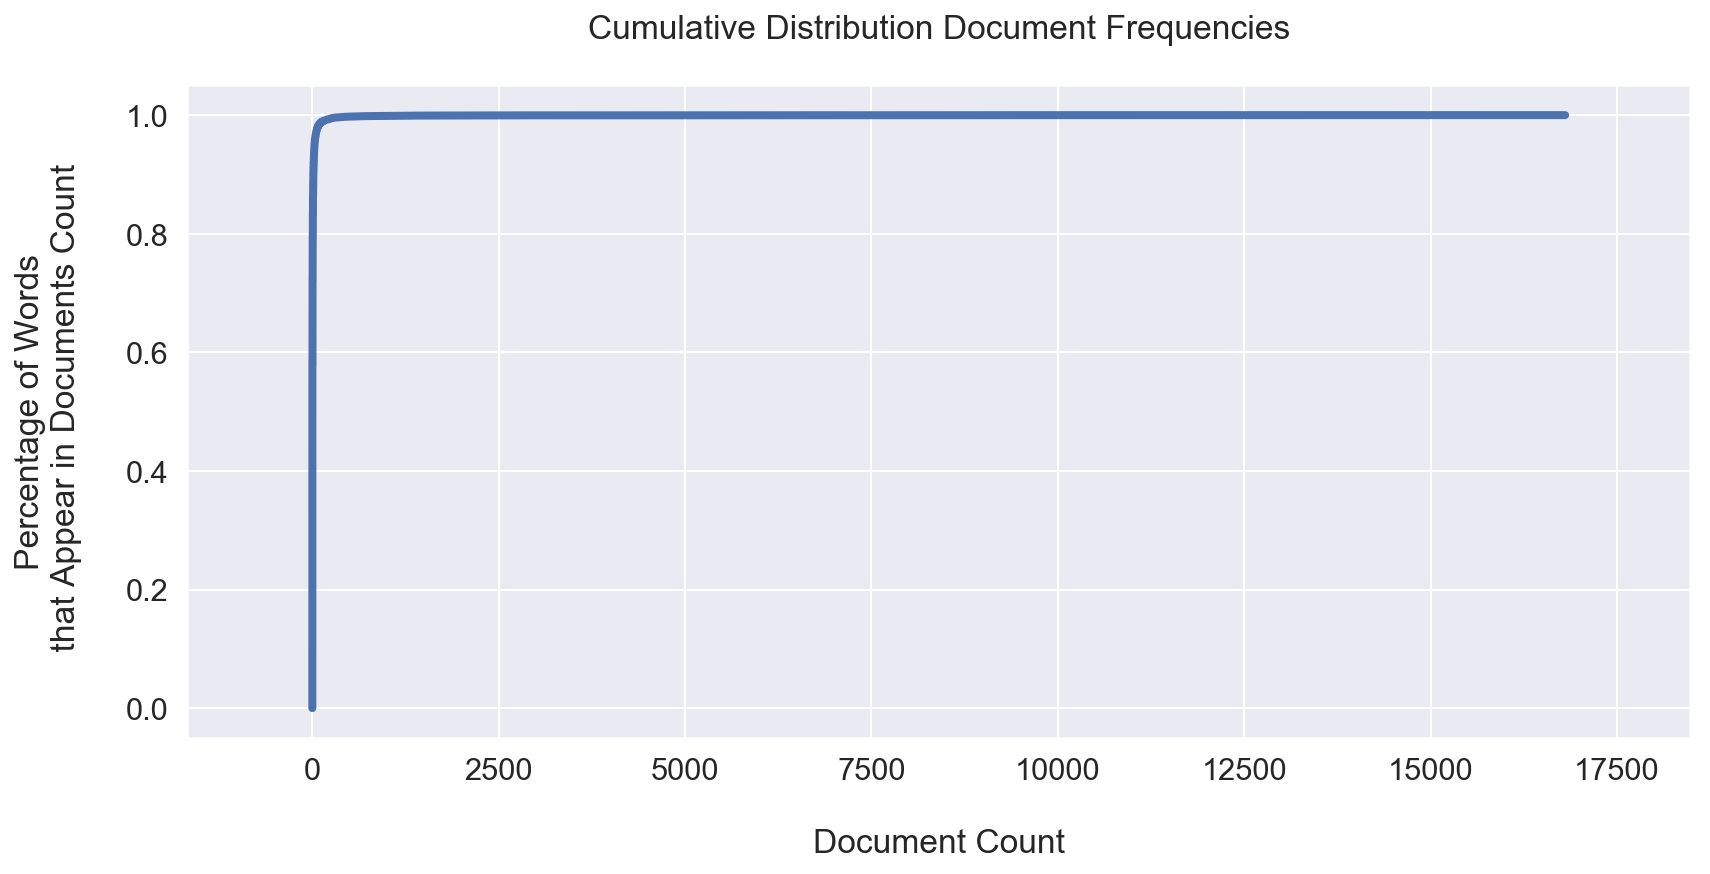

In [30]:
# plott cumulative distribution
_=sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 4})
_=plt.plot(x_axis,y_axis)
_=plt.title('Cumulative Distribution Document Frequencies\n')
_=plt.xlabel('\nDocument Count')
_=plt.ylabel('Percentage of Words\n that Appear in Documents Count\n')

<p>Due to the large number of documents is hard to see exactly the number of documents at which the curve begins climbing steeply to see a good value for the minimum number of documents a word should appear. Hence, a new plot limiting the number of documents being displayed.</p>

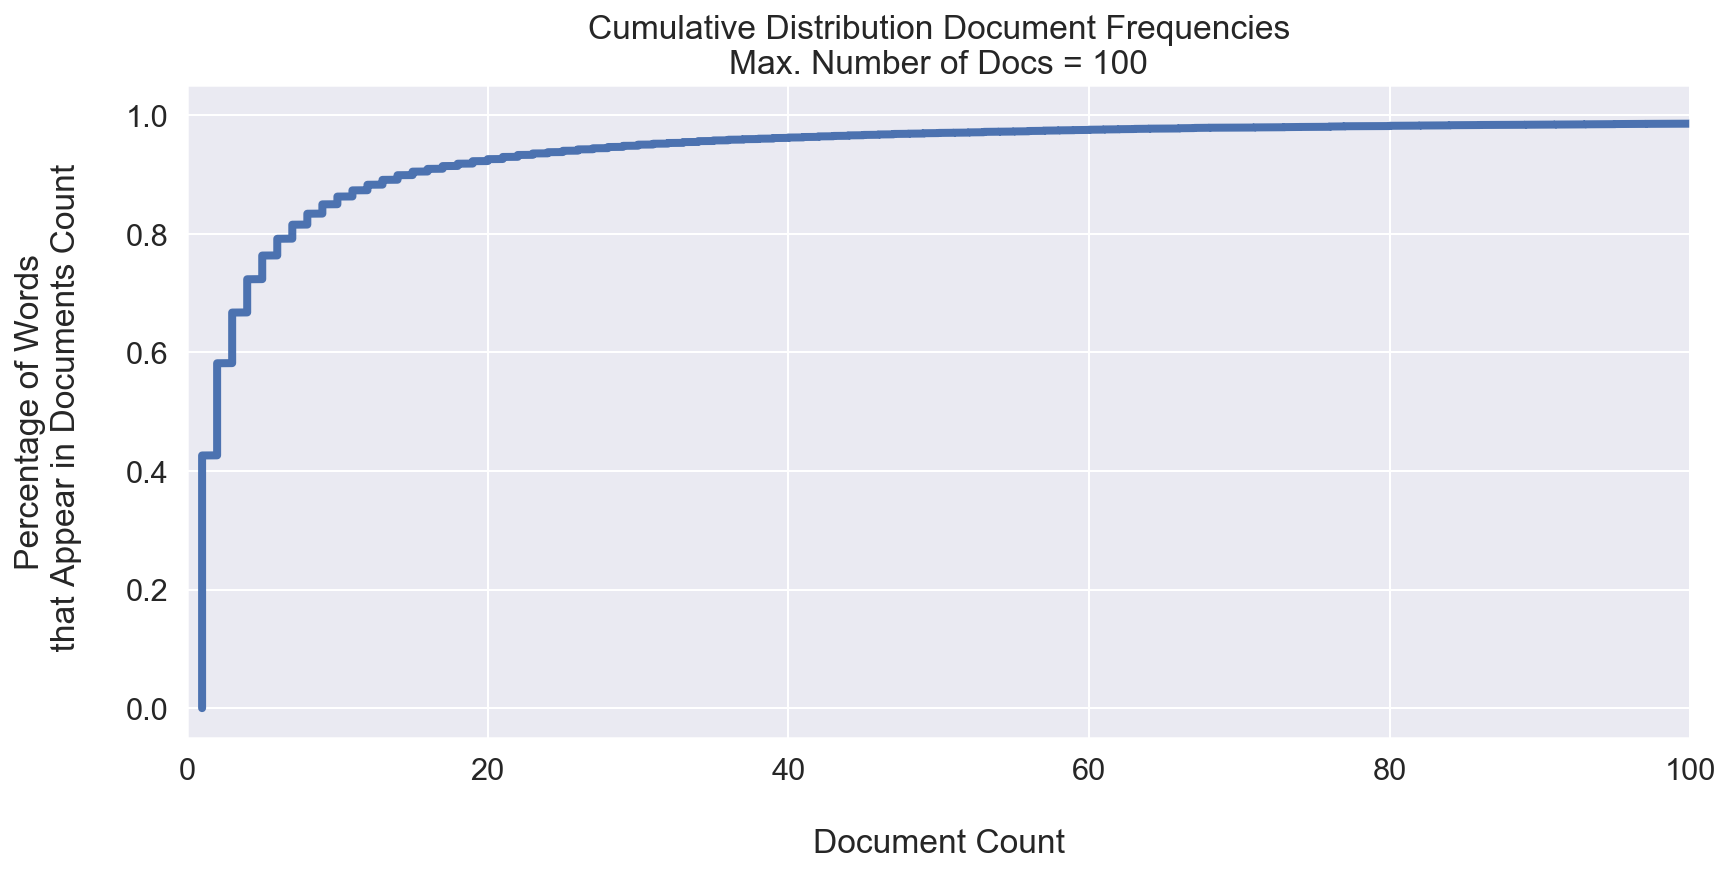

In [31]:
#plot cumulative distribution
_=plt.plot(x_axis,y_axis)
_=plt.title('Cumulative Distribution Document Frequencies\nMax. Number of Docs = 100')
_=plt.xlabel('\nDocument Count')
_=plt.ylabel('Percentage of Words\n that Appear in Documents Count\n')
_=plt.xlim(0,100)

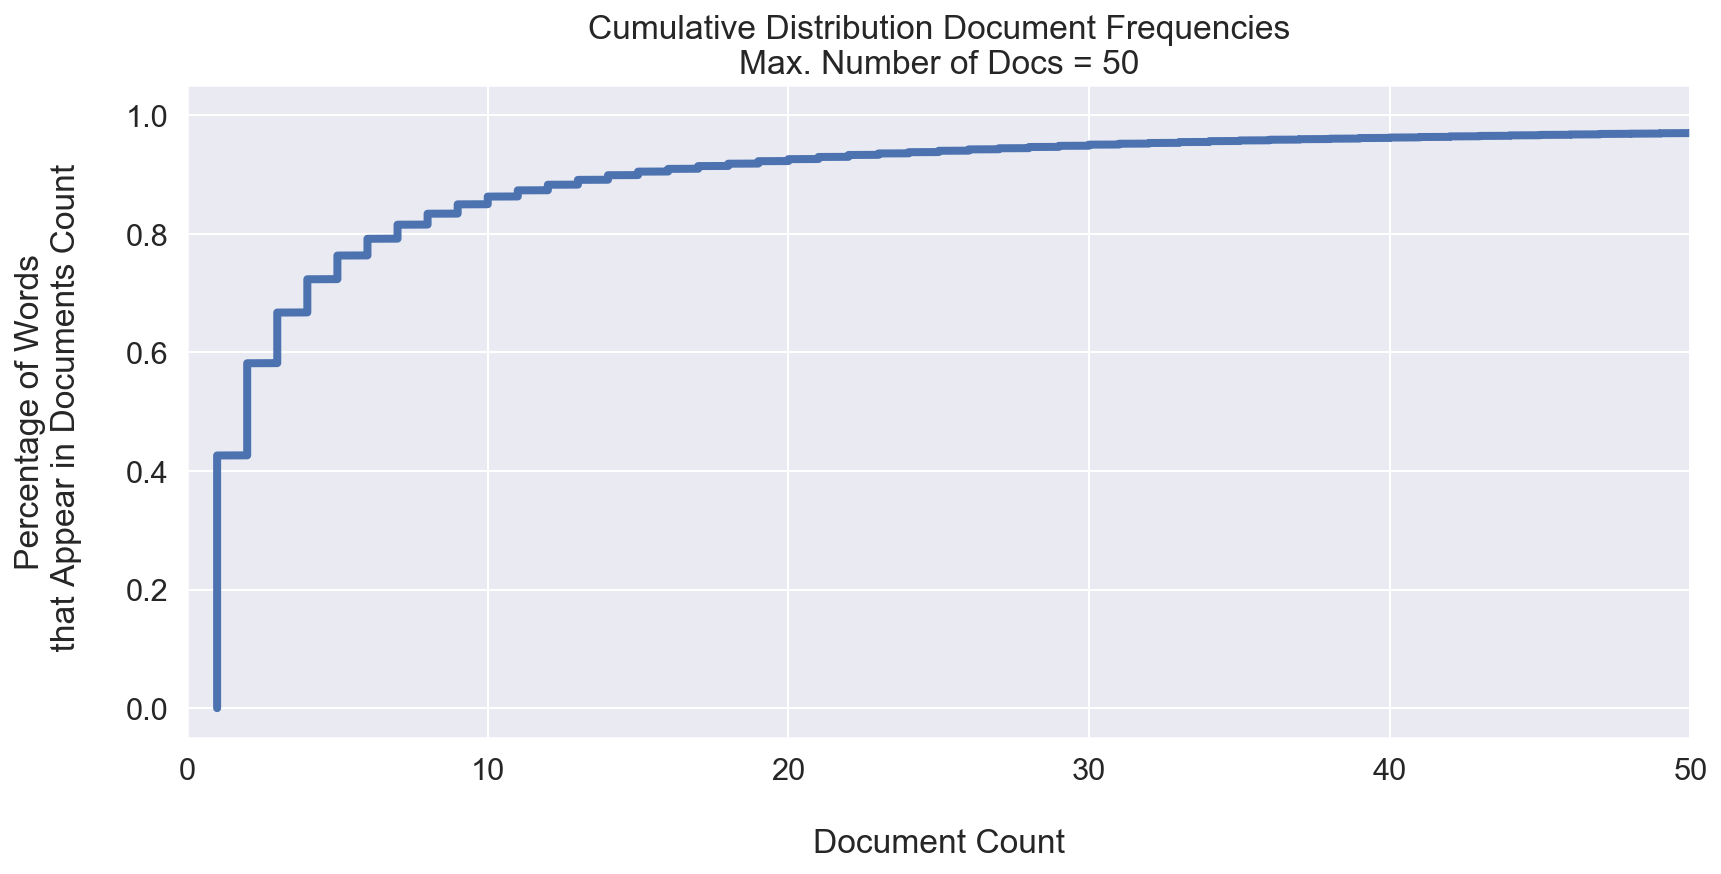

In [32]:
# plott cumulative distribution
_=plt.plot(x_axis,y_axis)
_=plt.title('Cumulative Distribution Document Frequencies\nMax. Number of Docs = 50')
_=plt.xlabel('\nDocument Count')
_=plt.ylabel('Percentage of Words\n that Appear in Documents Count\n')
_=plt.xlim(0,50)

<p>Looking at a smaller number of documents shows that the curve begins climbing steeply after one document. A new classifier was trained using a minimum of ten documents and a maximum of 30 to ignore terms that have a document frequency higher this.</p>

In [33]:
np.random.seed(2)
# get a new set of words
x_df, y_df = make_xy(critics, 'quote', max_df=30, min_df=10)

In [34]:
# split the data into train and test sets
xtrain_df, xtest_df, ytrain_df, ytest_df =train_test_split(x_df, y_df,test_size = 0.25, random_state = 2)#2 0.25

In [35]:
# initialize the classifier
nb_df = MultinomialNB()

#train the classifier
_=nb_df.fit(xtrain_df, ytrain_df)
# test the classifier on test set
pred_df = nb_df.predict(xtest_df)

In [36]:
# accuracy
print('accuracy on train set: %.3f'%(nb_df.score(xtrain_df, ytrain_df)))
print('accuracy on test set: %.3f'%(nb_df.score(xtest_df, ytest_df)))
print('Classification_report:')
print(classification_report(ytest_df, pred_df))

accuracy on train set: 0.921
accuracy on test set: 0.784
Classification_report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1494
           1       0.80      0.87      0.83      2397

   micro avg       0.78      0.78      0.78      3891
   macro avg       0.78      0.76      0.77      3891
weighted avg       0.78      0.78      0.78      3891



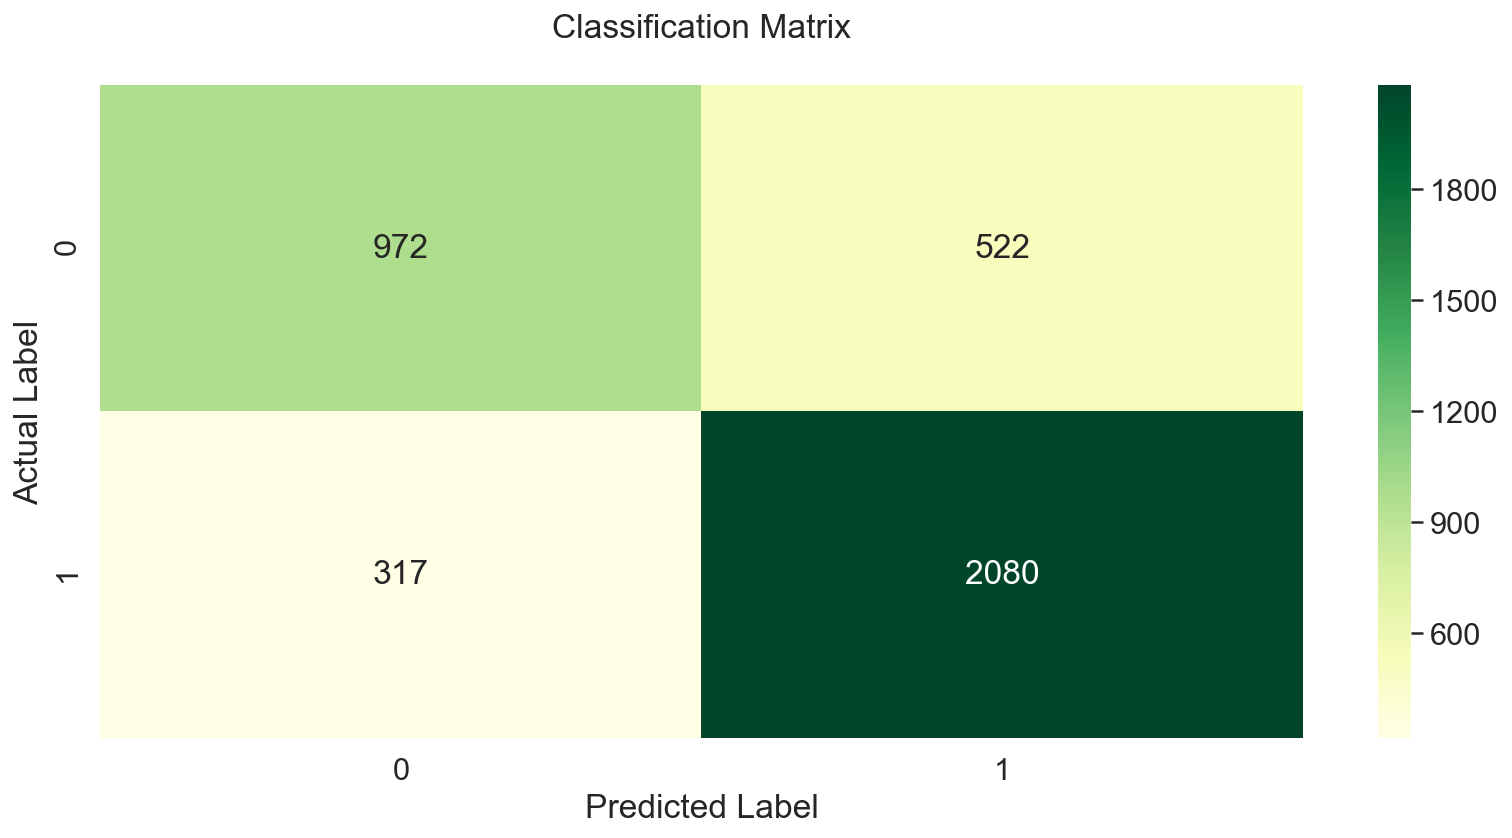

In [37]:
# plot classificaton accuracy
cm = metrics.confusion_matrix(ytest_df, pred_df)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)
_=sns.set(font_scale=1.4)
_=sns.heatmap(pd.DataFrame(cm), annot=True, fmt ='g', cmap='YlGn')
_=plt.title('Classification Matrix\n')
_=plt.xlabel('Predicted Label')
_=plt.ylabel('Actual Label')

#### Results:
<p>Using these parameters, the accuracy of the classifier only improved 1% in the test set, to 78%, and the training set still has 90% accuracy, showing the model is still over fitting the training dataset.</p>

<a id='tuningc'></a>

## Tuning the Classifier
#### Finding the 'best' $\alpha$ and <code>min_df </code>

<p>The following section uses K-fold cross-validation to evaluate and chose the best $\alpha$ parameter for the MultinomialNB classifier.</p>

In [38]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [39]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

<p>Using the log_likelihood custom function as the score mean helps optimize the probability of the classifier to not rely solely on the accuracy to measure performance.</p>

<p>The higher the $\alpha$ parameter the higher the likelihood having zeros in the probability computations.</p>

In [40]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

In [41]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df=None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        X_best, y_best = make_xy(critics, 'quote', vectorizer)
        Xtrain_best = X_best[mask]
        ytrain_best = y_best[mask]
    
        #initialize naive bayes model
        nb_best = MultinomialNB(alpha=alpha)
        scoring = cv_score(nb_best, Xtrain_best, ytrain_best, log_likelihood)
    
        if scoring > maxscore:
            maxscore = scoring
            best_alpha = alpha
            best_min_df = min_df

In [42]:
print("alpha: %d"%(best_alpha))
print("min_df: %d"%(best_min_df))

alpha: 5
min_df: 25


<a id='bulding'></a>

## Building the Classifier with the Best Parameters

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>


In [43]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, 'quote',vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

nb_tunned = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = nb_tunned.score(xtrain, ytrain)
test_accuracy = nb_tunned.score(xtest, ytest)

print("Accuracy on training data: %.3f"%(training_accuracy))
print("Accuracy on test data:     %.3f"%(test_accuracy))

Accuracy on training data: 0.783
Accuracy on test data:     0.705


In [44]:
from sklearn.metrics import confusion_matrix
cm_df = confusion_matrix(ytest, nb_tunned.predict(xtest))

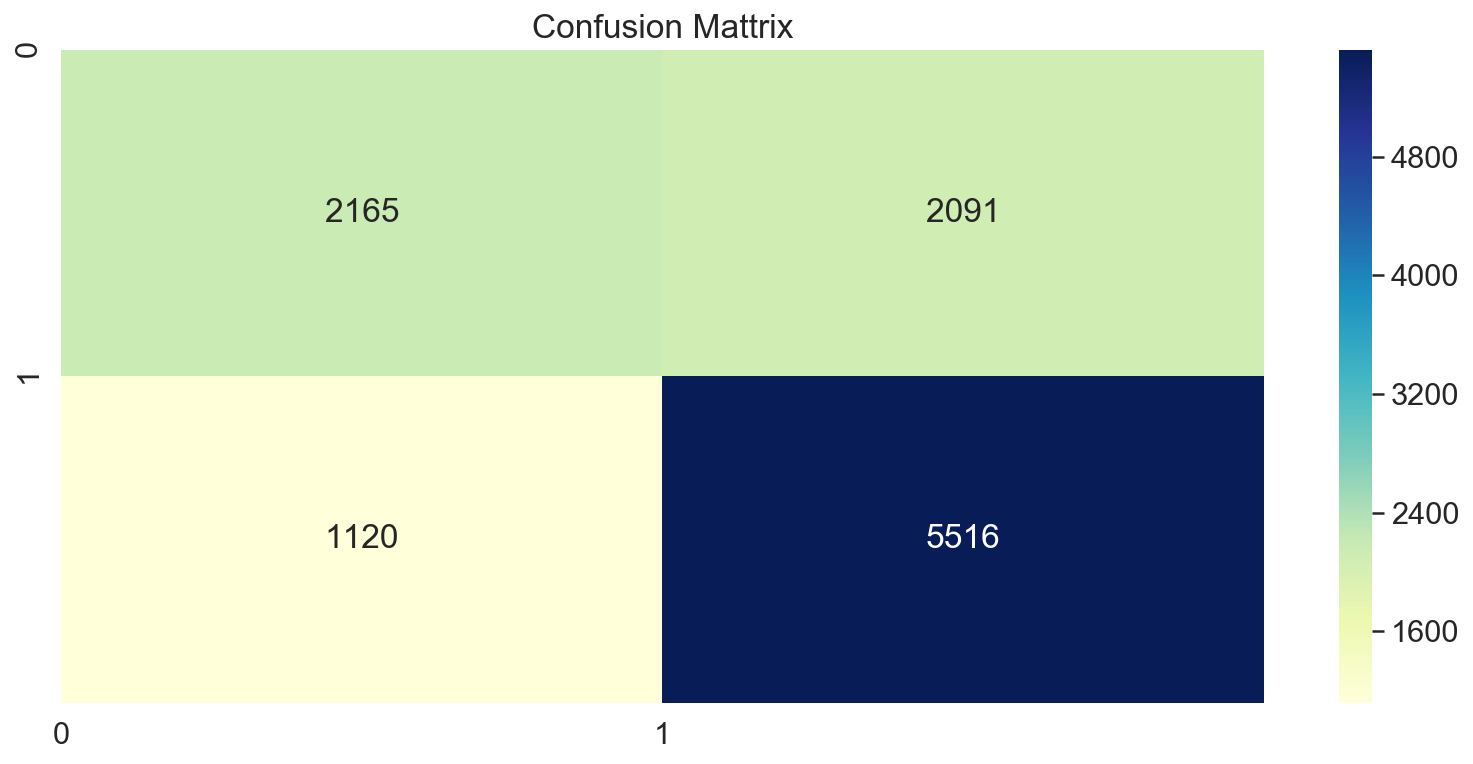

In [45]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=sns.heatmap(pd.DataFrame(cm_df), annot=True, fmt ='g', cmap='YlGnBu')
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)
_=plt.title('Confusion Mattrix')


#### Results:
<p>Using an $\alpha$ = 5 and 25 as the minimum number of documents a word must appear in, for it to be included in the vocabulary, the performance of the classifier improved. The accuracy in the train and test set decreased compared to the previous models, but the classifier is not overfitting the data.</p>

<a id='interpretation'></a>

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [46]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = nb_tunned.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
        entertaining 0.88
            powerful 0.85
         masterpiece 0.83
         beautifully 0.83
             likable 0.83
                rare 0.83
       entertainment 0.83
            stunning 0.82
               years 0.82
                best 0.82
Bad words	     P(fresh | word)
                thin 0.28
       disappointing 0.28
               fails 0.26
               feels 0.26
                dull 0.25
                 nor 0.25
       unfortunately 0.25
                lame 0.24
               bland 0.23
          uninspired 0.23


<p> Why does this method work? What does the probability for each row in the identity matrix represent?</p>
<p>Although the classifier is able to identify the likelihood of a word to appear in a positive reviews along with its probability to be positive or negative, the meaning of a single word without context can be ambiguous and not  represent the 'intent' of the writer. For instance, in the example above, the word <em>feels</em>was classify as a bad word based on the context used in the training text. However, the word can just as easily be used in positive reviews when followed by other words with positive connotations such as true or real.</p>

### Prediction Errors

We can see mis-predictions as well.

In [47]:
x, y = make_xy(critics, 'quote',vectorizer)

prob = nb_tunned.predict_proba(x)[:, 0]
predict = nb_tunned.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

Mis-predicted Fresh quotes
-----

<a id='newreview'></a>

# Predicting the Freshness for a New Review

<p>Using the best trained classifier, predict the freshness of the following sentence:</p>
<p>*'This movie is not remarkable, touching, or superb in any way'*</p>
<li> Is the result what you'd expect? Why (not)?</li>

In [48]:
review = ['This movie is not remarkable, touching, or superb in any way']

bow =vectorizer.transform(review)
new_review = nb_tunned.predict(bow)
print('positive review:', new_review==1)
print('probability:',nb_tunned.predict_proba(bow)[:, 1])


positive review: [ True]
probability: [0.86534171]


#### Result:
<p>Since the review used three words with positive connotations to emphasize what the movie <b>was lacking</b>, the classifier identified it as a positive review, as it was taking into consideration the total number of superlatives vs. the number of negative words.</p>

**** 

<a id='conclusions'></a>

# Conclusions

<p>The previous analysis used a subset of movie reviews to build a classifier that categorizes and scores reviews based on the words used to describe the movie. Three Naive Bayes classifiers were trained using different tuning parameters to avoid overfitting and optimizing the performance of the model.</p>
<p>The 'best' classifier obtained a 70% accuracy on unseen data. However, when using new reviews that contain words with positive connotations, the classifier did not perform well, as it is only considering the isolated words and not the context of the review.</p>

                                                                                                                                                          March 2019